### AAI 511 Final Project - Group 6
#### Zach Artman, Victor Hugo Germano, Diego Acevedo

In [1]:
# Imports and Setup
import os
import midi_access as midi # Helper functions in the midi_access.py file
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
import shutil
import pretty_midi
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

sns.set_theme(style="whitegrid")

BASE_MIDI_DIR = './dataset_module_7'  
ARTISTS_DIR = os.path.join(BASE_MIDI_DIR, 'all_files')

In [2]:
# Additional Helper Functions
def process_and_save_chunks_with_features(artist, song_idx, midi_data, output_dir, top_chords):
    chunks = midi.split_midi_into_chunks(midi_data, chunk_size=20.0)
    chunk_features = []
    for i, chunk in enumerate(chunks):
        # Generate filename and save chunk
        chunk_filename = f"{artist}_song{song_idx}_chunk{i}.mid"
        chunk_path = os.path.join(output_dir, chunk_filename)
        chunk.write(chunk_path)
        
        # Extract features for this chunk
        feature_vector = generate_feature_vector(chunk, top_chords)
        chunk_features.append({
            'artist': artist,
            'song_idx': song_idx,
            'chunk_idx': i,
            'chunk_path': chunk_path,
            'features': feature_vector
        })
    return chunk_features
def generate_feature_vector(midi_data, top_chords):
    pitch_hist = midi.get_pitch_class_histogram(midi_data)
    ioi_hist = midi.get_ioi_histogram(midi_data)
    chord_hist = midi.get_chord_histogram(midi_data, top_chords)
    return np.concatenate([pitch_hist, ioi_hist, chord_hist])
def extract_rolling_features(midi_data, window_size=10.0, step_size=5.0):
    max_time = midi_data.get_end_time()
    start_times = np.arange(0, max_time - window_size + step_size, step_size)
    pitch_means, velocity_means, key_change_counts, times = [], [], [], []

    for start in start_times:
        end = start + window_size
        notes_in_window = []
        velocities_in_window = []
        for inst in midi_data.instruments:
            for note in inst.notes:
                if note.start >= start and note.start < end:
                    notes_in_window.append(note.pitch)
                    velocities_in_window.append(note.velocity)
        pitch_mean = np.mean(notes_in_window) if notes_in_window else np.nan
        velocity_mean = np.mean(velocities_in_window) if velocities_in_window else np.nan
        key_changes = [
            ksc.time for ksc in getattr(midi_data, 'key_signature_changes', [])
            if start <= ksc.time < end
        ]
        key_change_count = len(key_changes)
        pitch_means.append(pitch_mean)
        velocity_means.append(velocity_mean)
        key_change_counts.append(key_change_count)
        times.append(start + window_size / 2)
    return pd.DataFrame({
        'time': times,
        'pitch_mean': pitch_means,
        'velocity_mean': velocity_means,
        'key_change_count': key_change_counts
    })
def extract_tempo_features(pm):
    tempos, _ = pm.get_tempo_changes()
    return float(np.mean(tempos)), float(np.std(tempos))

def extract_note_stats(pm):
    pitches = [note.pitch for inst in pm.instruments for note in inst.notes]
    return len(pitches), len(set(pitches))

def extract_features(pm, top_chords):
    # reuse your pitch, IOI and chord histograms
    pitch = midi.get_pitch_class_histogram(pm)
    ioi   = midi.get_ioi_histogram(pm)
    chord = midi.get_chord_histogram(pm, top_chords)
    avg_t, std_t = extract_tempo_features(pm)
    total_n, uniq_n = extract_note_stats(pm)
    return np.concatenate([pitch, ioi, chord, [avg_t, std_t, total_n, uniq_n]])

### Data Collection: Data is collected and provided to you.

In [3]:
# Load all songs by artist
artist_midi_dict = midi.load_midi_files_by_artist(ARTISTS_DIR)

/opt/homebrew/anaconda3/envs/masters/lib/python3.12/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error loading ./dataset_module_7/all_files/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


### Data Pre-processing: Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI files and applying data augmentation techniques.


In [4]:
all_chunk_features = []
output_dir = os.path.join(BASE_MIDI_DIR, 'intermediate_chunks')

# Clean up the output directory if it exists
if os.path.exists(output_dir):
    print(f"Removing existing output directory: {output_dir}")  
    shutil.rmtree(output_dir)

# Create the output directory
print(f"Creating output directory: {output_dir}")
os.makedirs(output_dir, exist_ok=True)
top_chords = midi.get_top_chords(artist_midi_dict, top_n=20)

# Process each artist's MIDI files and extract features
for artist, song_list in artist_midi_dict.items():
    print(f"Processing artist: {artist} with {len(song_list)} songs")
    for idx, midi_data in enumerate(song_list):
        chunk_features = process_and_save_chunks_with_features(artist, idx, midi_data, output_dir, top_chords)
        all_chunk_features.extend(chunk_features)


df_chunks = pd.DataFrame(all_chunk_features)
print(f"Total chunks processed: {len(df_chunks)}")
print(f"Saving chunk features to: {os.path.join(output_dir, './songs_by_artist_chunk_features.csv')}")

df_chunks.to_csv(os.path.join(output_dir, './songs_by_artist_chunk_features.csv'), index=False)

df_chunks.head()

Removing existing output directory: ./dataset_module_7/intermediate_chunks
Creating output directory: ./dataset_module_7/intermediate_chunks
Processing artist: Mozart with 90 songs


/opt/homebrew/anaconda3/envs/masters/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges


Processing artist: Chopin with 136 songs
Processing artist: Beethoven with 132 songs
Processing artist: Bach with 122 songs
Total chunks processed: 7695
Saving chunk features to: ./dataset_module_7/intermediate_chunks/./songs_by_artist_chunk_features.csv


,artist,song_idx,chunk_idx,chunk_path,features
0,Mozart,0,0,./dataset_module_7/intermediate_chunks/Mozart_...,"[0.07242990654205607, 0.0, 0.05373831775700934..."
1,Mozart,0,1,./dataset_module_7/intermediate_chunks/Mozart_...,"[0.006928406466512702, 0.0023094688221709007, ..."
2,Mozart,0,2,./dataset_module_7/intermediate_chunks/Mozart_...,"[0.08794788273615635, 0.024429967426710098, 0...."
3,Mozart,0,3,./dataset_module_7/intermediate_chunks/Mozart_...,"[0.05782312925170068, 0.023809523809523808, 0...."
4,Mozart,0,4,./dataset_module_7/intermediate_chunks/Mozart_...,"[0.0443213296398892, 0.00554016620498615, 0.03..."


### EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7695 entries, 0 to 7694
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   artist      7695 non-null   object
 1   song_idx    7695 non-null   int64 
 2   chunk_idx   7695 non-null   int64 
 3   chunk_path  7695 non-null   object
 4   features    7695 non-null   object
dtypes: int64(2), object(3)
memory usage: 300.7+ KB


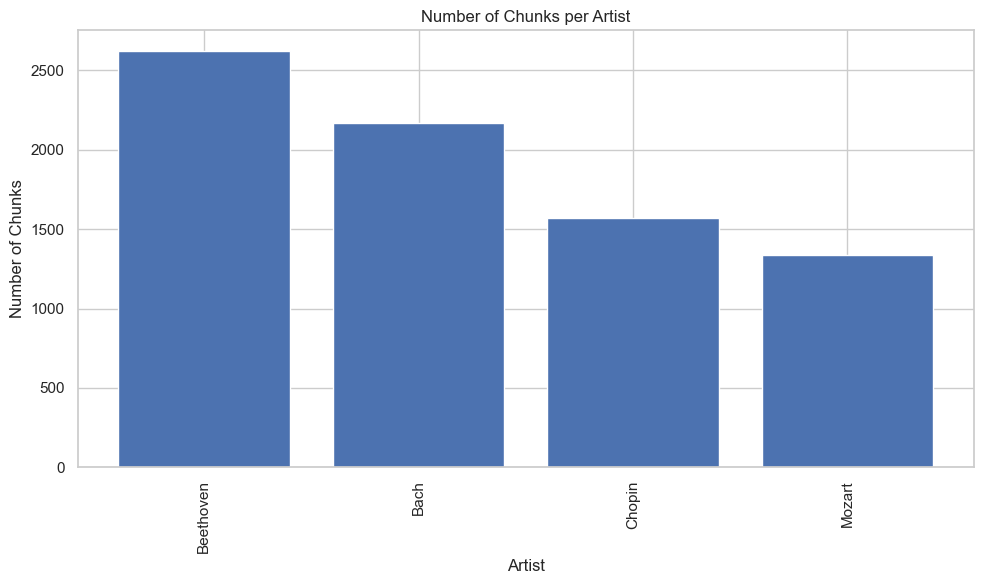

In [ ]:
df_chunks.info()

chunk_counts = df_chunks['artist'].value_counts()

plt.figure(figsize=(10, 5))
plt.bar(chunk_counts.index, chunk_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Artist')
plt.ylabel('Number of Chunks')
plt.title('Number of Chunks per Artist')
plt.tight_layout()
plt.show()

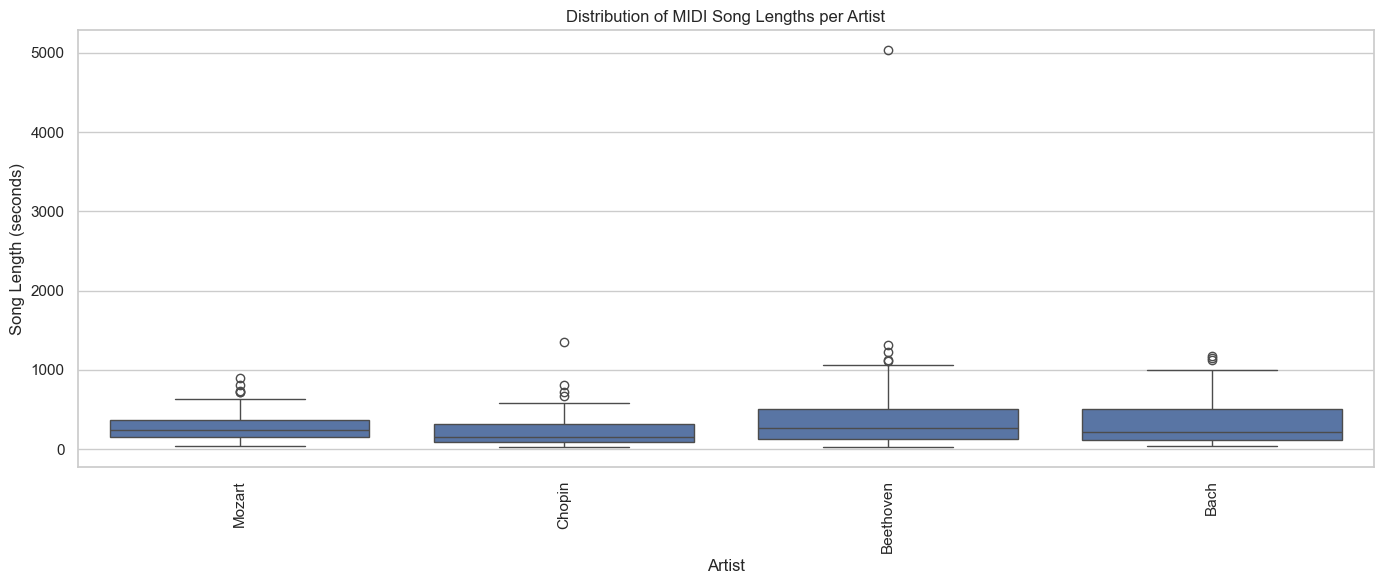

In [ ]:
# Collect lengths and artists
data = []
for artist, midi_list in artist_midi_dict.items():
    for midi_data in midi_list:
        length = midi_data.get_end_time()
        data.append({'artist': artist, 'length': length})

df = pd.DataFrame(data)

plt.figure(figsize=(10, 5))
sns.boxplot(x='artist', y='length', data=df)
plt.xticks(rotation=90)
plt.xlabel('Artist')
plt.ylabel('Song Length (seconds)')
plt.title('Distribution of MIDI Song Lengths per Artist')
plt.tight_layout()
plt.show()

In [7]:
# Remove Beethoven outlier
df = df[df['length'] <= 1000]

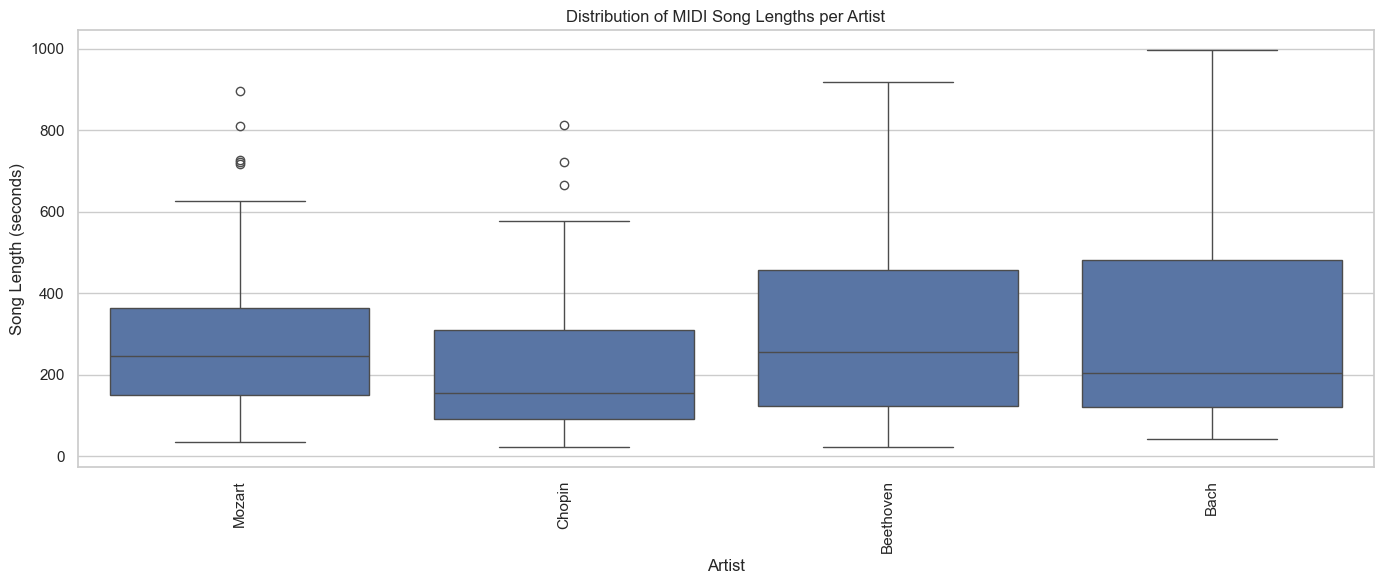

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='artist', y='length', data=df)
plt.xticks(rotation=90)
plt.xlabel('Artist')
plt.ylabel('Song Length (seconds)')
plt.title('Distribution of MIDI Song Lengths per Artist')
plt.tight_layout()
plt.show()

#### Artist Feature Examples

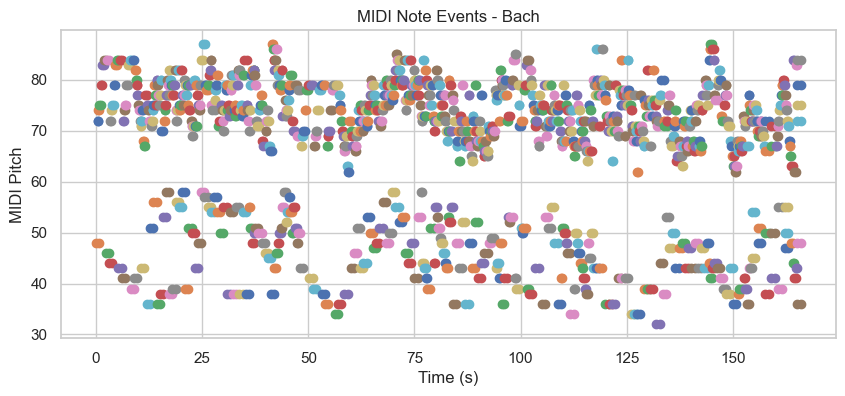

In [9]:
top_chords = midi.get_top_chords(artist_midi_dict, top_n=20)
midi_data = artist_midi_dict[artist][0]  

# Visualize the MIDI data
def visualize_midi(midi_data):
    plt.figure(figsize=(10, 4))
    plt.title(f'MIDI Note Events - {artist}')
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            plt.plot([note.start, note.end], [note.pitch, note.pitch], marker='o')
    plt.xlabel('Time (s)')
    plt.ylabel('MIDI Pitch')
    plt.show()

visualize_midi(midi_data)

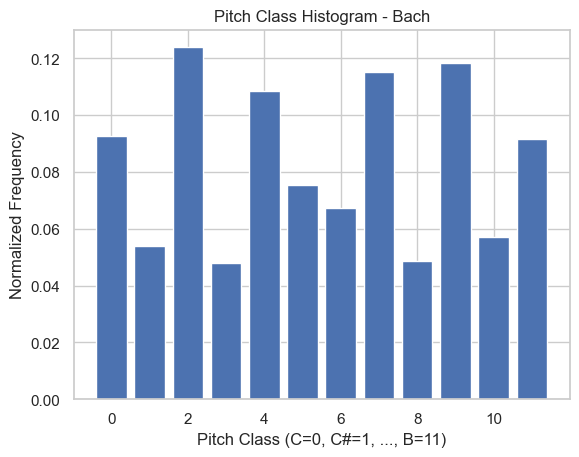

In [10]:
# Aggregate for all MIDI files of an artist
pitch_class_hist = np.zeros(12)
for song in artist_midi_dict[artist]:
    pitch_class_hist += midi.get_pitch_class_histogram(song)
pitch_class_hist /= len(artist_midi_dict[artist])

plt.bar(range(12), pitch_class_hist)
plt.xlabel('Pitch Class (C=0, C#=1, ..., B=11)')
plt.ylabel('Normalized Frequency')
plt.title(f'Pitch Class Histogram - {artist}')
plt.show()

Chord (4, 7): 3336 times
Chord (2, 5): 3221 times
Chord (0, 9): 3108 times
Chord (2, 11): 2950 times
Chord (7, 11): 2571 times
Chord (7, 10): 2521 times
Chord (6, 9): 2448 times
Chord (0, 4): 2417 times
Chord (2, 6): 2167 times
Chord (0, 3): 2166 times
Chord (5, 9): 2095 times
Chord (2, 10): 1937 times
Chord (3, 7): 1847 times
Chord (1, 4): 1845 times
Chord (1, 9): 1771 times


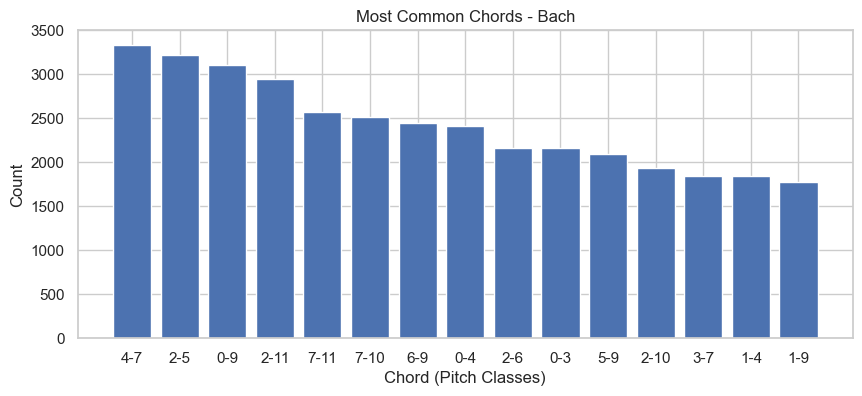

In [11]:
chord_counter = Counter()
for song in artist_midi_dict[artist]:
    chords = midi.extract_chords(song)
    chord_counter.update(chords)

# Show the most common chords (as pitch class sets)
most_common_chords = chord_counter.most_common(15)
for chord, count in most_common_chords:
    print(f"Chord {chord}: {count} times")

# Optional: Bar plot of top chords
labels = ['-'.join(map(str, chord)) for chord, _ in most_common_chords]
counts = [count for _, count in most_common_chords]
plt.figure(figsize=(10, 4))
plt.bar(labels, counts)
plt.xlabel('Chord (Pitch Classes)')
plt.ylabel('Count')
plt.title(f'Most Common Chords - {artist}')
plt.show()

In [12]:
# Example: get tensor for 'Bach'
feature_tensor = midi.get_artist_feature_tensor(artist_midi_dict[artist], top_chords)
print("Feature tensor shape:", feature_tensor.shape)
print("Feature tensor:", feature_tensor)

Feature tensor shape: (52,)
Feature tensor: [9.25685998e-02 5.39163553e-02 1.23898824e-01 4.79325651e-02
 1.08584585e-01 7.52442497e-02 6.71333655e-02 1.15117692e-01
 4.85153962e-02 1.18374051e-01 5.72067900e-02 9.15075258e-02
 4.59459432e+00 2.89139901e+00 1.60893215e+00 3.40654649e-01
 3.67230890e-01 8.37211422e-02 3.18247698e-02 1.55733123e-02
 2.14484463e-02 2.47985805e-02 3.80323863e-03 2.74355407e-03
 2.77366559e-03 2.96716896e-03 1.23337241e-03 9.01363641e-04
 8.21895822e-04 1.14330105e-03 1.45436500e-03 1.98079809e-03
 8.64570825e-02 2.02841543e-02 5.61918287e-02 8.77505633e-02
 7.07564000e-02 1.54293780e-02 7.12113328e-02 2.51570670e-02
 6.41719593e-02 1.94885204e-02 3.18794199e-02 6.27457710e-02
 7.46098935e-02 5.10207942e-02 4.33310033e-02 1.23939655e-02
 4.79424917e-02 2.45504424e-02 9.88977033e-02 2.75335103e-02]


#### Artist Differentiation: Determining which features have better variance between artists

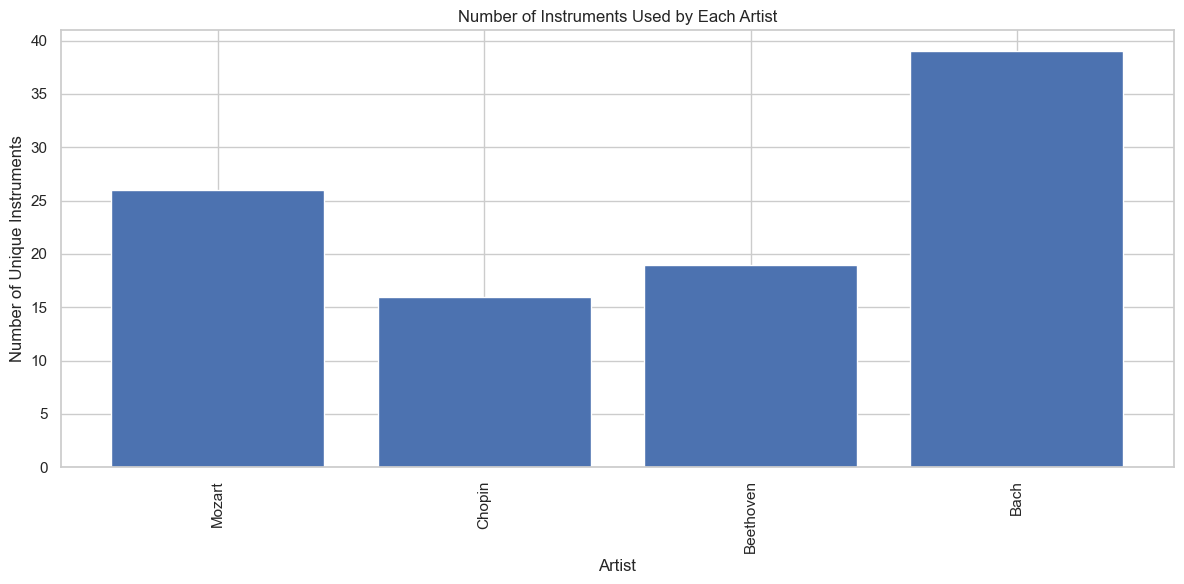

In [13]:
# Count unique instruments per artist
num_instruments_by_artist = {}
for artist, midi_list in artist_midi_dict.items():
    instruments = set()
    for midi_data in midi_list:
        for inst in midi_data.instruments:
            instruments.add(inst.program)
    num_instruments_by_artist[artist] = len(instruments)

plt.figure(figsize=(12, 6))
plt.bar(num_instruments_by_artist.keys(), num_instruments_by_artist.values())
plt.xticks(rotation=90)
plt.xlabel('Artist')
plt.ylabel('Number of Unique Instruments')
plt.title('Number of Instruments Used by Each Artist')
plt.tight_layout()

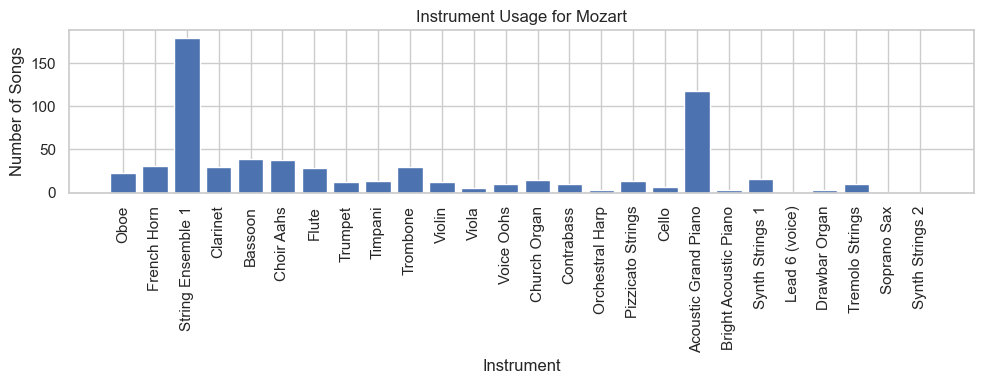

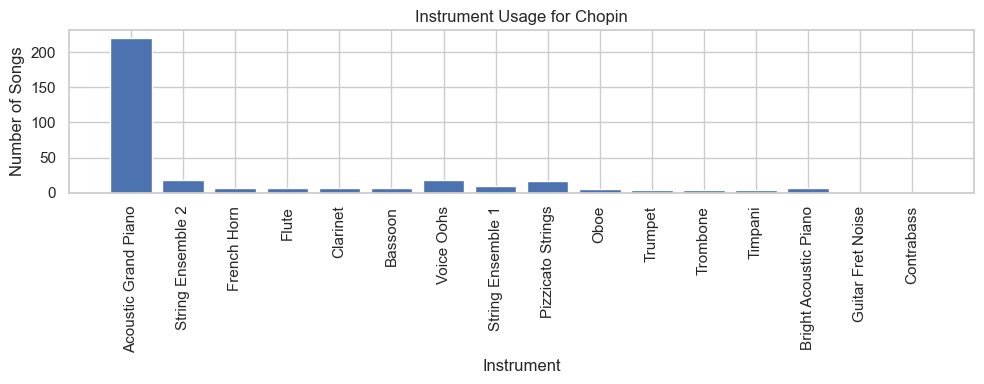

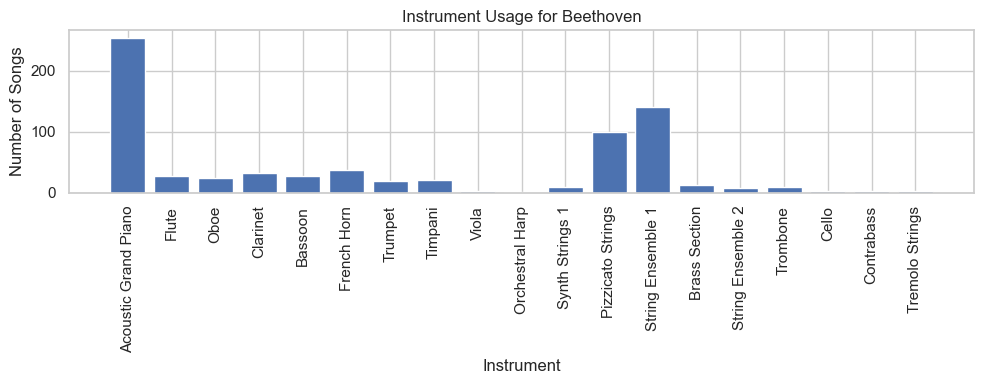

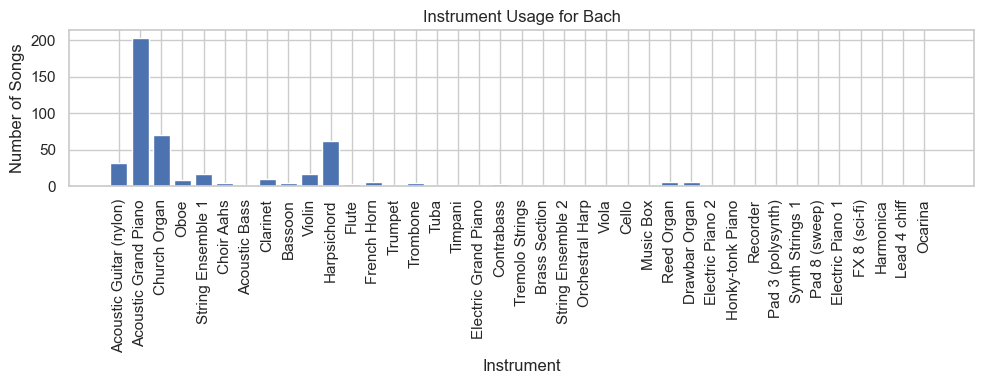

In [14]:
for artist, midi_list in artist_midi_dict.items():
    instruments = set()
    for midi_data in midi_list:
        for inst in midi_data.instruments:
            instruments.add(inst.program)
    instrument_names = [pretty_midi.program_to_instrument_name(prog) for prog in instruments]


for artist, midi_list in artist_midi_dict.items():
    instrument_counter = Counter()
    for midi_data in midi_list:
        for inst in midi_data.instruments:
            instrument_counter[inst.program] += 1
    instrument_names = [pretty_midi.program_to_instrument_name(prog) for prog in instrument_counter.keys()]
    counts = list(instrument_counter.values())
    plt.figure(figsize=(10, 4))
    plt.bar(instrument_names, counts)
    plt.xticks(rotation=90)
    plt.title(f'Instrument Usage for {artist}')
    plt.xlabel('Instrument')
    plt.ylabel('Number of Songs')
    plt.tight_layout()
    plt.show()

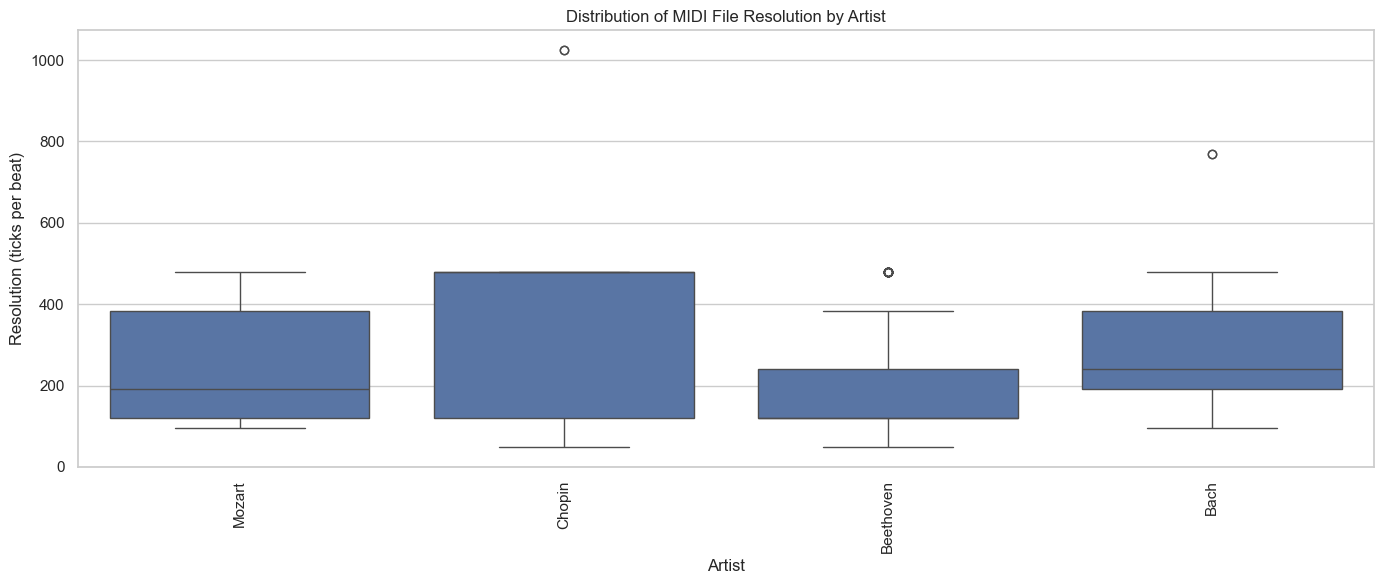

In [ ]:
# Resolution of the MIDI files
'''
Resolution typically refers to the smallest unit of time 
that can be distinguished or represented in your MIDI data.

For MIDI files, this is often called "ticks per beat" or "PPQ" (Pulses Per Quarter note). 
It determines how finely you can represent timing, note onsets, durations, 
and other temporal events in the music. 
Higher resolution means more precise timing information.
'''
import matplotlib.pyplot as plt

# Collect resolution for each song
resolution_data = []
for artist, midi_list in artist_midi_dict.items():
    for midi_data in midi_list:
        resolution_data.append({'artist': artist, 'resolution': midi_data.resolution})

df_resolution = pd.DataFrame(resolution_data)

plt.figure(figsize=(10, 5))
sns.boxplot(x='artist', y='resolution', data=df_resolution)
plt.xticks(rotation=90)
plt.xlabel('Artist')
plt.ylabel('Resolution (ticks per beat)')
plt.title('Distribution of MIDI File Resolution by Artist')
plt.tight_layout()
plt.show()

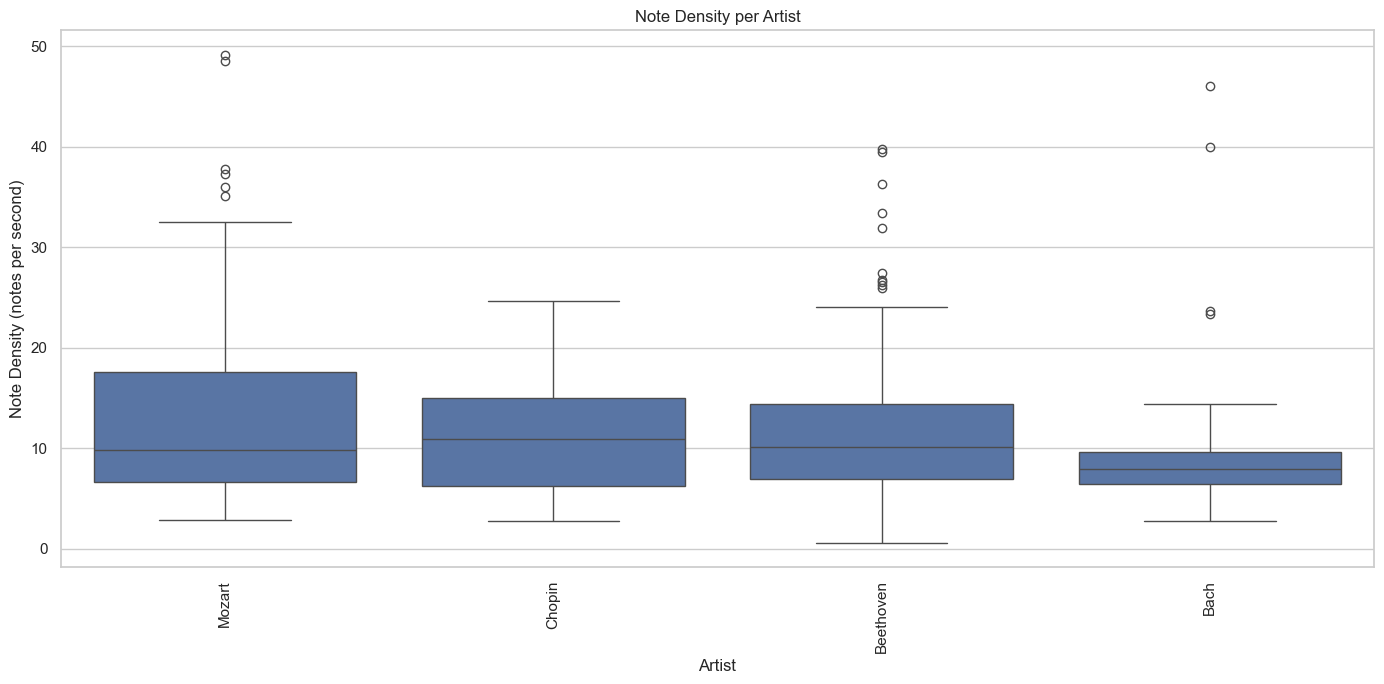

In [16]:
note_density_data = []
for artist, midi_list in artist_midi_dict.items():
    for midi_data in midi_list:
        num_notes = sum(len(inst.notes) for inst in midi_data.instruments)
        duration = midi_data.get_end_time()
        if duration > 0:
            note_density = num_notes / duration
            note_density_data.append({'artist': artist, 'note_density': note_density})

# Aggregate into DataFrame
df_note_density = pd.DataFrame(note_density_data)

plt.figure(figsize=(14, 7))
sns.boxplot(x='artist', y='note_density', data=df_note_density)
plt.xticks(rotation=90)
plt.xlabel('Artist')
plt.ylabel('Note Density (notes per second)')
plt.title('Note Density per Artist')
plt.tight_layout()
plt.show()

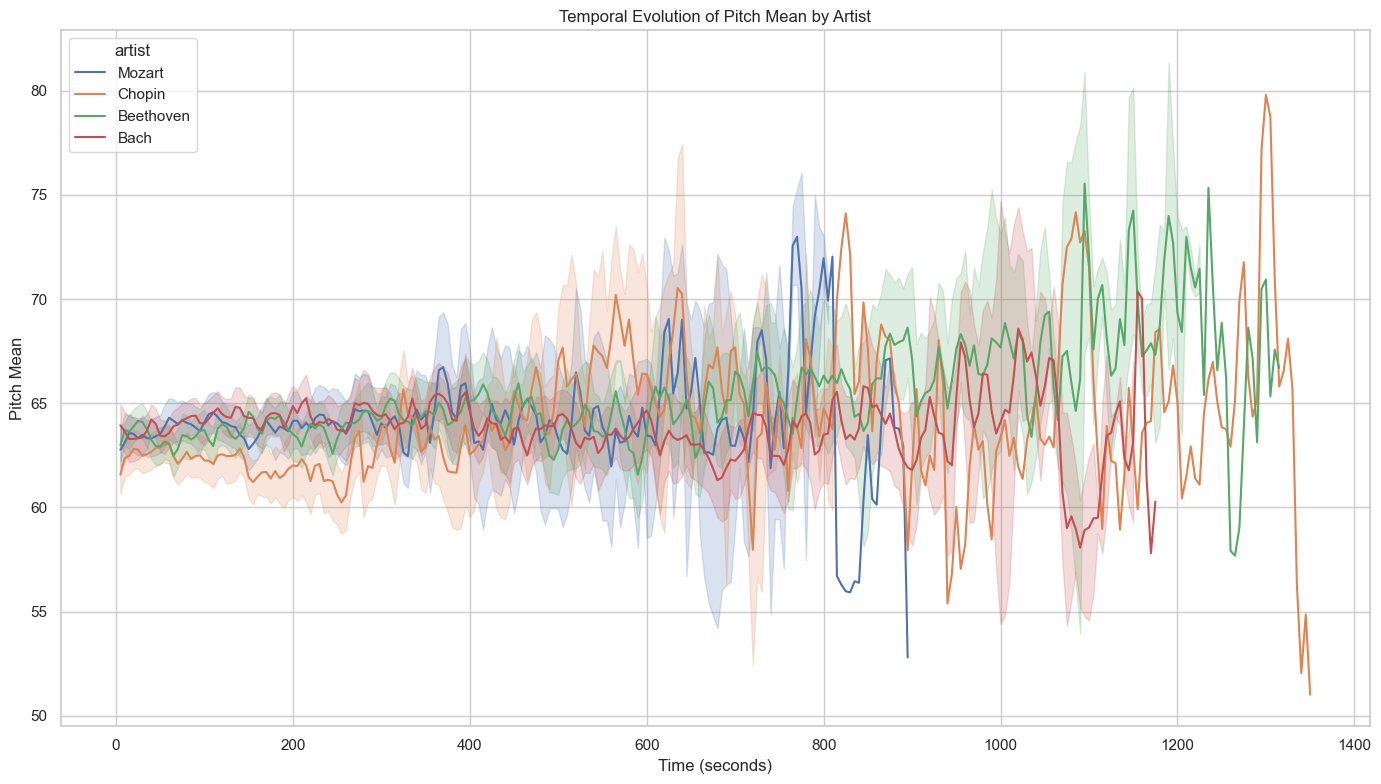

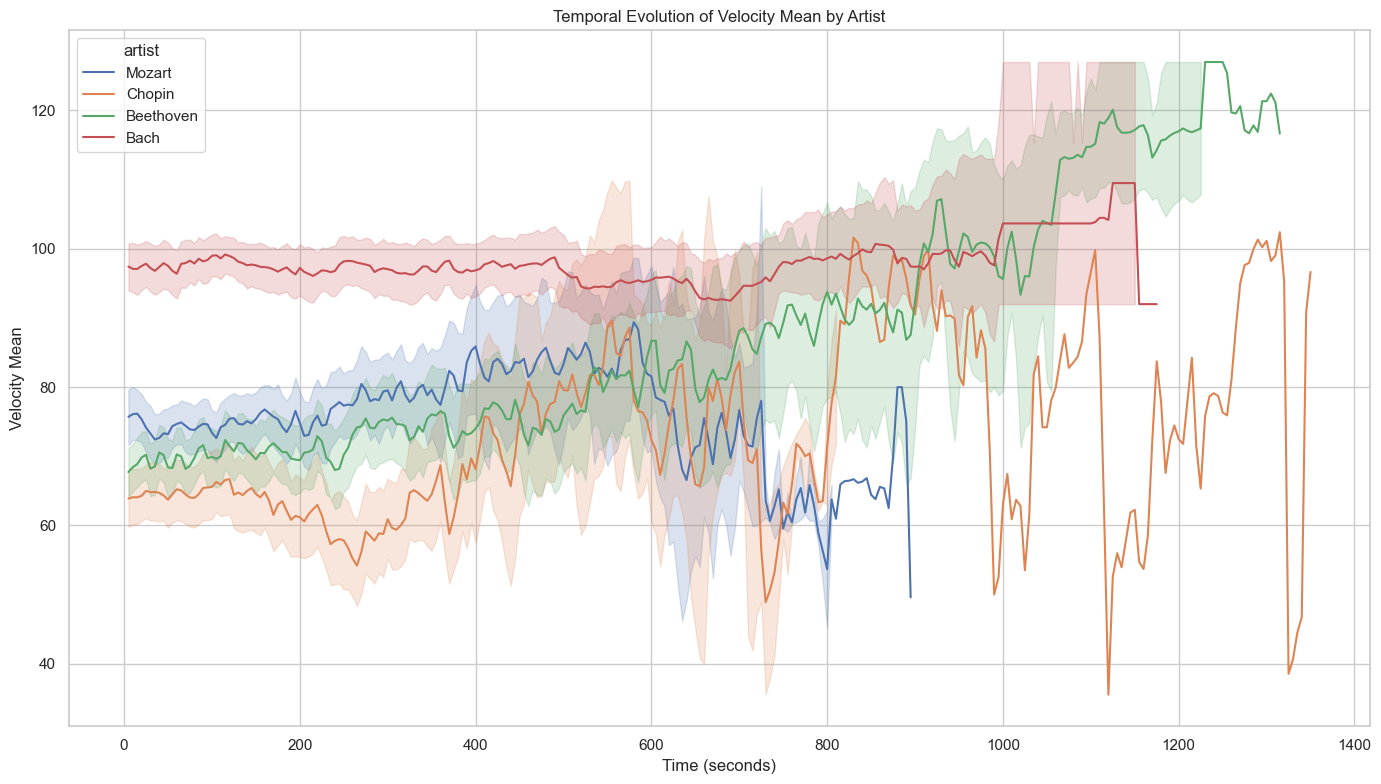

In [17]:
# Create a dataframe for all artists' rolling features
df_list = []
for artist, midi_list in artist_midi_dict.items():
    for midi_data in midi_list:
        features = extract_rolling_features(midi_data)
        features['artist'] = artist
        df_list.append(features)

df_features = pd.concat(df_list, ignore_index=True)

plt.figure(figsize=(14, 8))
sns.lineplot(data=df_features, x='time', y='pitch_mean', hue='artist', legend='full')
plt.title('Temporal Evolution of Pitch Mean by Artist')
plt.xlabel('Time (seconds)')
plt.ylabel('Pitch Mean')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
sns.lineplot(data=df_features, x='time', y='velocity_mean', hue='artist', legend='full')
plt.title('Temporal Evolution of Velocity Mean by Artist')
plt.xlabel('Time (seconds)')
plt.ylabel('Velocity Mean')
plt.tight_layout()
plt.show()

### Feature Extraction: Extract features from the MIDI files, such as notes, chords, and tempo, using music analysis tools.


In [18]:
# build a DataFrame of per‐song features
song_features = []
for artist, song_list in artist_midi_dict.items():
    for idx, pm in enumerate(song_list):
        fv = extract_features(pm, top_chords)
        song_features.append({'artist': artist, 'song_idx': idx, 'features': fv})

df_song_features = pd.DataFrame(song_features)

In [19]:
df_song_features

,artist,song_idx,features
0,Mozart,0,"[0.06876872592381224, 0.010700527892709373, 0...."
1,Mozart,1,"[0.15384615384615385, 0.02234162895927602, 0.1..."
2,Mozart,2,"[0.008246649798519351, 0.09783525442788867, 0...."
3,Mozart,3,"[0.15336898395721926, 0.01411764705882353, 0.1..."
4,Mozart,4,"[0.20614568365203936, 0.007626837625732287, 0...."
...,...,...,...
475,Bach,117,"[0.0, 0.1256637168141593, 0.1079646017699115, ..."
476,Bach,118,"[0.09408142319534725, 0.041908997605200136, 0...."
477,Bach,119,"[0.00423728813559322, 0.134180790960452, 0.137..."
478,Bach,120,"[0.14699792960662525, 0.022774327122153208, 0...."


In [20]:
df_song_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   artist    480 non-null    object
 1   song_idx  480 non-null    int64 
 2   features  480 non-null    object
dtypes: int64(1), object(2)
memory usage: 11.4+ KB


In [21]:
# CNN Inputs
X = np.vstack(df_song_features['features'].values)
y = LabelEncoder().fit_transform(df_song_features['artist'])
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
X_cnn_train = X_train[..., None]
X_cnn_val   = X_val[..., None]

In [22]:
# LSTM inputs
seqs, labels = [], []
for _, row in df_song_features.iterrows():
    pm = artist_midi_dict[row['artist']][row['song_idx']]
    df_roll = extract_rolling_features(pm).fillna(0)
    seqs.append(df_roll[['pitch_mean','velocity_mean','key_change_count']].values)
    labels.append(row['artist'])
y_seq = LabelEncoder().fit_transform(labels)
X_seq = pad_sequences(seqs, maxlen=100, dtype='float32', padding='post')
X_seq_train, X_seq_val, y_seq_train, y_seq_val = train_test_split(
    X_seq, y_seq, stratify=y_seq, test_size=0.2, random_state=42
)

### Model 1: Develop a deep learning model using LSTM to classify the musical scores according to the composer.

This model uses stacked LSTM layers to classify classical compositions by composer, based on rolling window features extracted from MIDI files. Specifically, it uses pitch mean, velocity mean, and key change count features aggregated over time. The sequences are padded to a fixed length of 100 and one-hot encoded.

After training the model for 30 epochs, it achieved approximately **43% validation accuracy**. The model shows stronger performance for some composers over others, indicating room for improvement via hyperparameter tuning or more advanced feature engineering.

In [23]:
# LSTM Input Prep

from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences

seqs, labels = [], []

# Build sequences from features
for _, row in df_song_features.iterrows():
    pm = artist_midi_dict[row['artist']][row['song_idx']]
    df_roll = extract_rolling_features(pm).fillna(0)
    seqs.append(df_roll[['pitch_mean', 'velocity_mean', 'key_change_count']].values)
    labels.append(row['artist'])

# Encode labels and pad sequences
y_seq = LabelEncoder().fit_transform(labels)
X_seq = pad_sequences(seqs, maxlen=100, dtype='float32', padding='post')

# One hot encode labels
from keras.utils import to_categorical
y_seq = to_categorical(y_seq)

# Train/test split
from sklearn.model_selection import train_test_split

X_seq_train, X_seq_val, y_seq_train, y_seq_val = train_test_split(
    X_seq, y_seq, stratify=y_seq, test_size=0.2, random_state=42
)


In [24]:
# LSTM Model and Training

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.optimizers import Adam

# Building LSTM model
model_lstm = Sequential()
model_lstm.add(Input(shape=(X_seq_train.shape[1], X_seq_train.shape[2])))
model_lstm.add(LSTM(128, return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(64))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(y_seq_train.shape[1], activation='softmax'))

# Compile the model
model_lstm.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

# Print summary
model_lstm.summary()

# Training model
history = model_lstm.fit(
    X_seq_train, y_seq_train,
    validation_data=(X_seq_val, y_seq_val),
    epochs=30,
    batch_size=64,
    verbose=1
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 128)       │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,412 (474.27 KB)

 Trainable params: 121,412 (474.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.2929 - loss: 1.3795 - val_accuracy: 0.4271 - val_loss: 1.3267
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3832 - loss: 1.3245 - val_accuracy: 0.4167 - val_loss: 1.2999
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3785 - loss: 1.2954 - val_accuracy: 0.4271 - val_loss: 1.2664
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4017 - loss: 1.2879 - val_accuracy: 0.5000 - val_loss: 1.1778
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4475 - loss: 1.2444 - val_accuracy: 0.4167 - val_loss: 1.3746
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3895 - loss: 1.3879 - val_accuracy: 0.4062 - val_loss: 1.2747
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3433 - loss: 1.3140 - val_accuracy: 0.4062 - val_loss: 1.2752
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3548 - loss: 1.3129 - val_accuracy: 0.4062 - val_loss: 1.2853


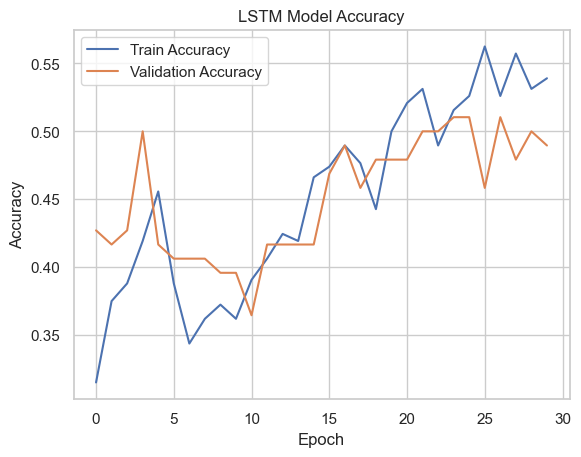

In [25]:
# training history plot

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LSTM Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
# Model Eval

from sklearn.metrics import classification_report
import numpy as np

# Predict on validation data
y_pred = model_lstm.predict(X_seq_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_seq_val, axis=1)

# Classification report
print(classification_report(y_true_labels, y_pred_labels))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

           0       0.70      0.84      0.76        25
           1       0.38      0.46      0.41        26
           2       0.48      0.48      0.48        27
           3       0.14      0.06      0.08        18

    accuracy                           0.49        96
   macro avg       0.42      0.46      0.43        96
weighted avg       0.45      0.49      0.46        96



### Model 2: Develop a deep learning model using CNN to classify the musical scores according to the composer.


In [27]:
# CNN Architecture
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam

# Training with callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        # First convolutional block
        Input(shape=input_shape),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        
        # Second convolutional block
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        
        # Third convolutional block
        Conv1D(filters=256, kernel_size=3, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        
        # Flatten and dense layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model



### Model Training: Train the deep learning model using the pre-processed and feature-extracted data.

In [28]:

# Create the CNN model
model_cnn = create_cnn_model(input_shape=(X_cnn_train.shape[1], 1), num_classes=len(np.unique(y_train)))

# Compile model
model_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5)
]

history_cnn = model_cnn.fit(
    X_cnn_train, y_train,
    validation_data=(X_cnn_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2702 - loss: 2.4774 - val_accuracy: 0.3438 - val_loss: 1.3741 - learning_rate: 0.0010
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3491 - loss: 1.8864 - val_accuracy: 0.3125 - val_loss: 1.3678 - learning_rate: 0.0010
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4897 - loss: 1.5303 - val_accuracy: 0.3438 - val_loss: 1.3445 - learning_rate: 0.0010
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5110 - loss: 1.4416 - val_accuracy: 0.3021 - val_loss: 1.3534 - learning_rate: 0.0010
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5176 - loss: 1.3773 - val_accuracy: 0.2500 - val_loss: 1.3399 - learning_rate: 0.0010
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5039 - loss: 1.2303 - val_accuracy: 0.2708 - val_loss: 1.3185 - learning_rate: 0.0010
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5363 - loss: 1.2834 - val_ac

#### Training Results

CNN Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 54, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 54, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 27, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 27, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 25, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,704,910 (17.95 MB)

 Trainable params: 1,568,004 (5.98 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 3,136,010 (11.96 MB)

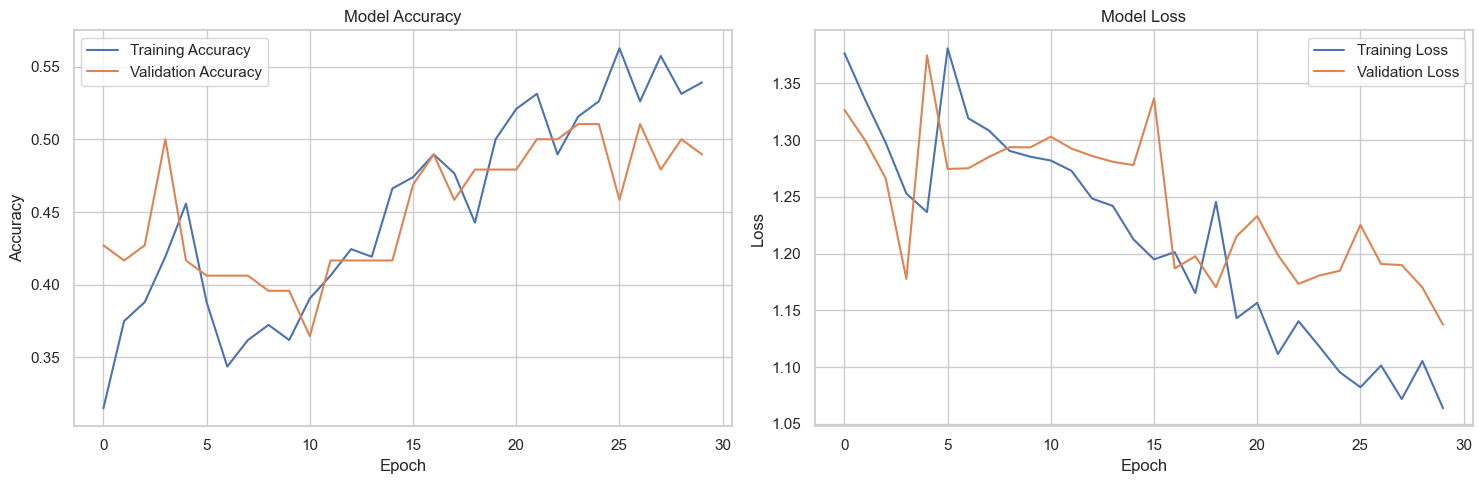


Final Training Accuracy: 0.5391
Final Validation Accuracy: 0.4896
Total epochs trained: 30


In [29]:
# Display model summary
print("CNN Model Architecture:")
model_cnn.summary()

# Display training progress
plt.figure(figsize=(15, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final training results
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Total epochs trained: {len(history.history['accuracy'])}")

#### Model Evaluation

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Classification Report:
              precision    recall  f1-score   support

        Bach       0.76      0.88      0.81        25
   Beethoven       0.49      0.77      0.60        26
      Chopin       0.76      0.59      0.67        27
      Mozart       0.60      0.17      0.26        18

    accuracy                           0.64        96
   macro avg       0.65      0.60      0.58        96
weighted avg       0.66      0.64      0.61        96



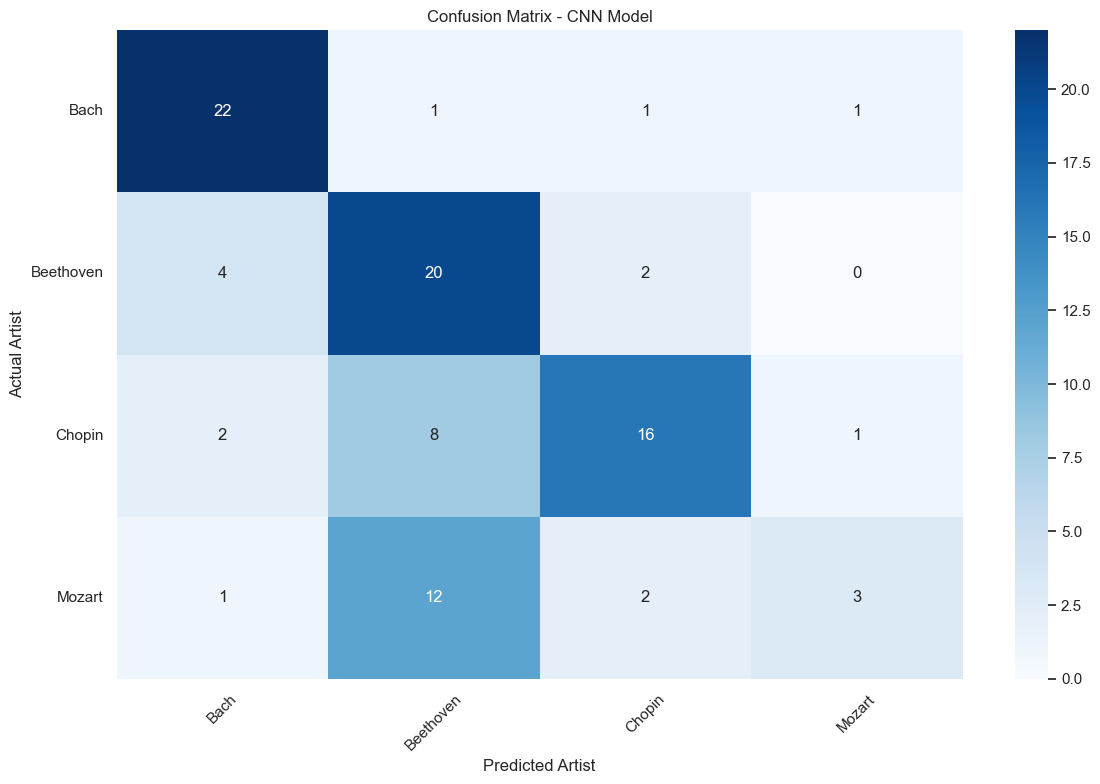

Bach: 0.880 accuracy
Beethoven: 0.769 accuracy
Chopin: 0.593 accuracy
Mozart: 0.167 accuracy


In [30]:
# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Make predictions
y_pred = model_cnn.predict(X_cnn_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get artist names for labels
le = LabelEncoder()
le.fit(df_song_features['artist'])
artist_names = le.classes_

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, target_names=artist_names))

# Confusion Matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_val, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=artist_names, yticklabels=artist_names)
plt.title('Confusion Matrix - CNN Model')
plt.xlabel('Predicted Artist')
plt.ylabel('Actual Artist')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, artist in enumerate(artist_names):
    print(f"{artist}: {class_accuracy[i]:.3f} accuracy")

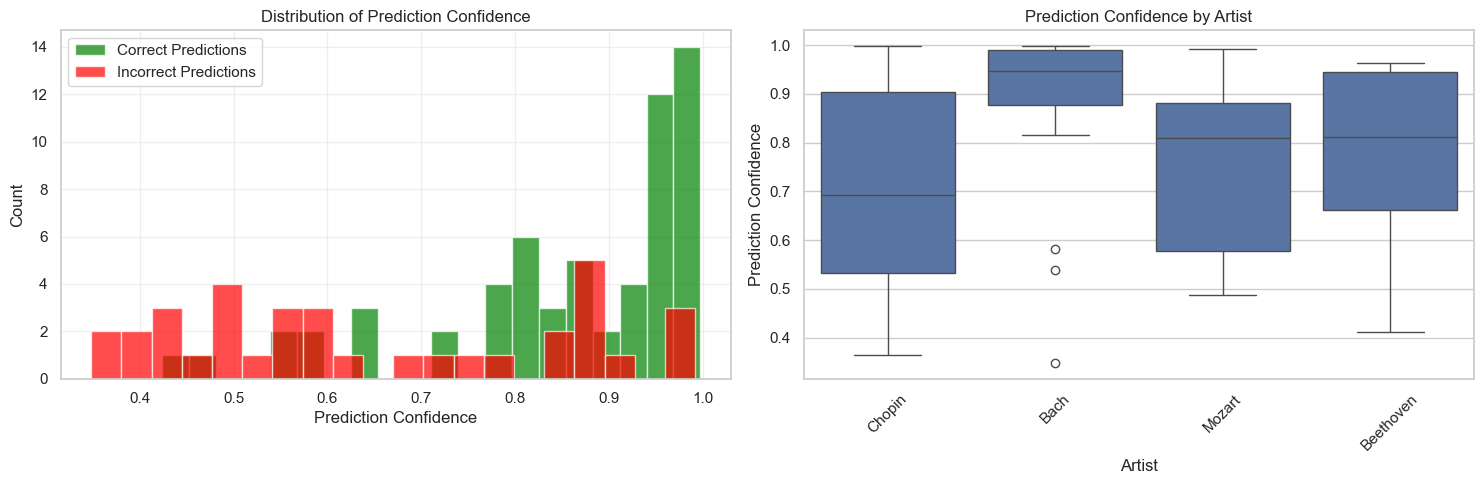


Low Confidence Predictions (confidence < 0.6):
       actual  predicted  confidence  correct
60       Bach  Beethoven    0.348115    False
25     Chopin  Beethoven    0.364664    False
67  Beethoven     Chopin    0.410732    False
62     Chopin  Beethoven    0.411728    False
9      Chopin       Bach    0.415814    False
8   Beethoven  Beethoven    0.423884     True
45  Beethoven     Chopin    0.429922    False
15     Chopin       Bach    0.430365    False
88     Chopin  Beethoven    0.454374    False
11  Beethoven  Beethoven    0.466609     True


In [31]:
# Prediction Confidence Analysis
confidence_scores = np.max(y_pred, axis=1)
prediction_confidence = pd.DataFrame({
    'actual': [artist_names[i] for i in y_val],
    'predicted': [artist_names[i] for i in y_pred_classes],
    'confidence': confidence_scores,
    'correct': y_val == y_pred_classes
})

# Confidence distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(prediction_confidence[prediction_confidence['correct']]['confidence'], 
         alpha=0.7, label='Correct Predictions', bins=20, color='green')
plt.hist(prediction_confidence[~prediction_confidence['correct']]['confidence'], 
         alpha=0.7, label='Incorrect Predictions', bins=20, color='red')
plt.xlabel('Prediction Confidence')
plt.ylabel('Count')
plt.title('Distribution of Prediction Confidence')
plt.legend()
plt.grid(True, alpha=0.3)

# Confidence by artist
plt.subplot(1, 2, 2)
sns.boxplot(data=prediction_confidence, x='actual', y='confidence')
plt.xticks(rotation=45)
plt.xlabel('Artist')
plt.ylabel('Prediction Confidence')
plt.title('Prediction Confidence by Artist')

plt.tight_layout()
plt.show()

# Print some low confidence predictions for analysis
print("\nLow Confidence Predictions (confidence < 0.6):")
low_confidence = prediction_confidence[prediction_confidence['confidence'] < 0.6].sort_values('confidence')
print(low_confidence.head(10))

### Model Comparison Evaluation: Evaluate the performance of both models using accuracy, precision, and recall metrics.


ML MODEL COMPARISON
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


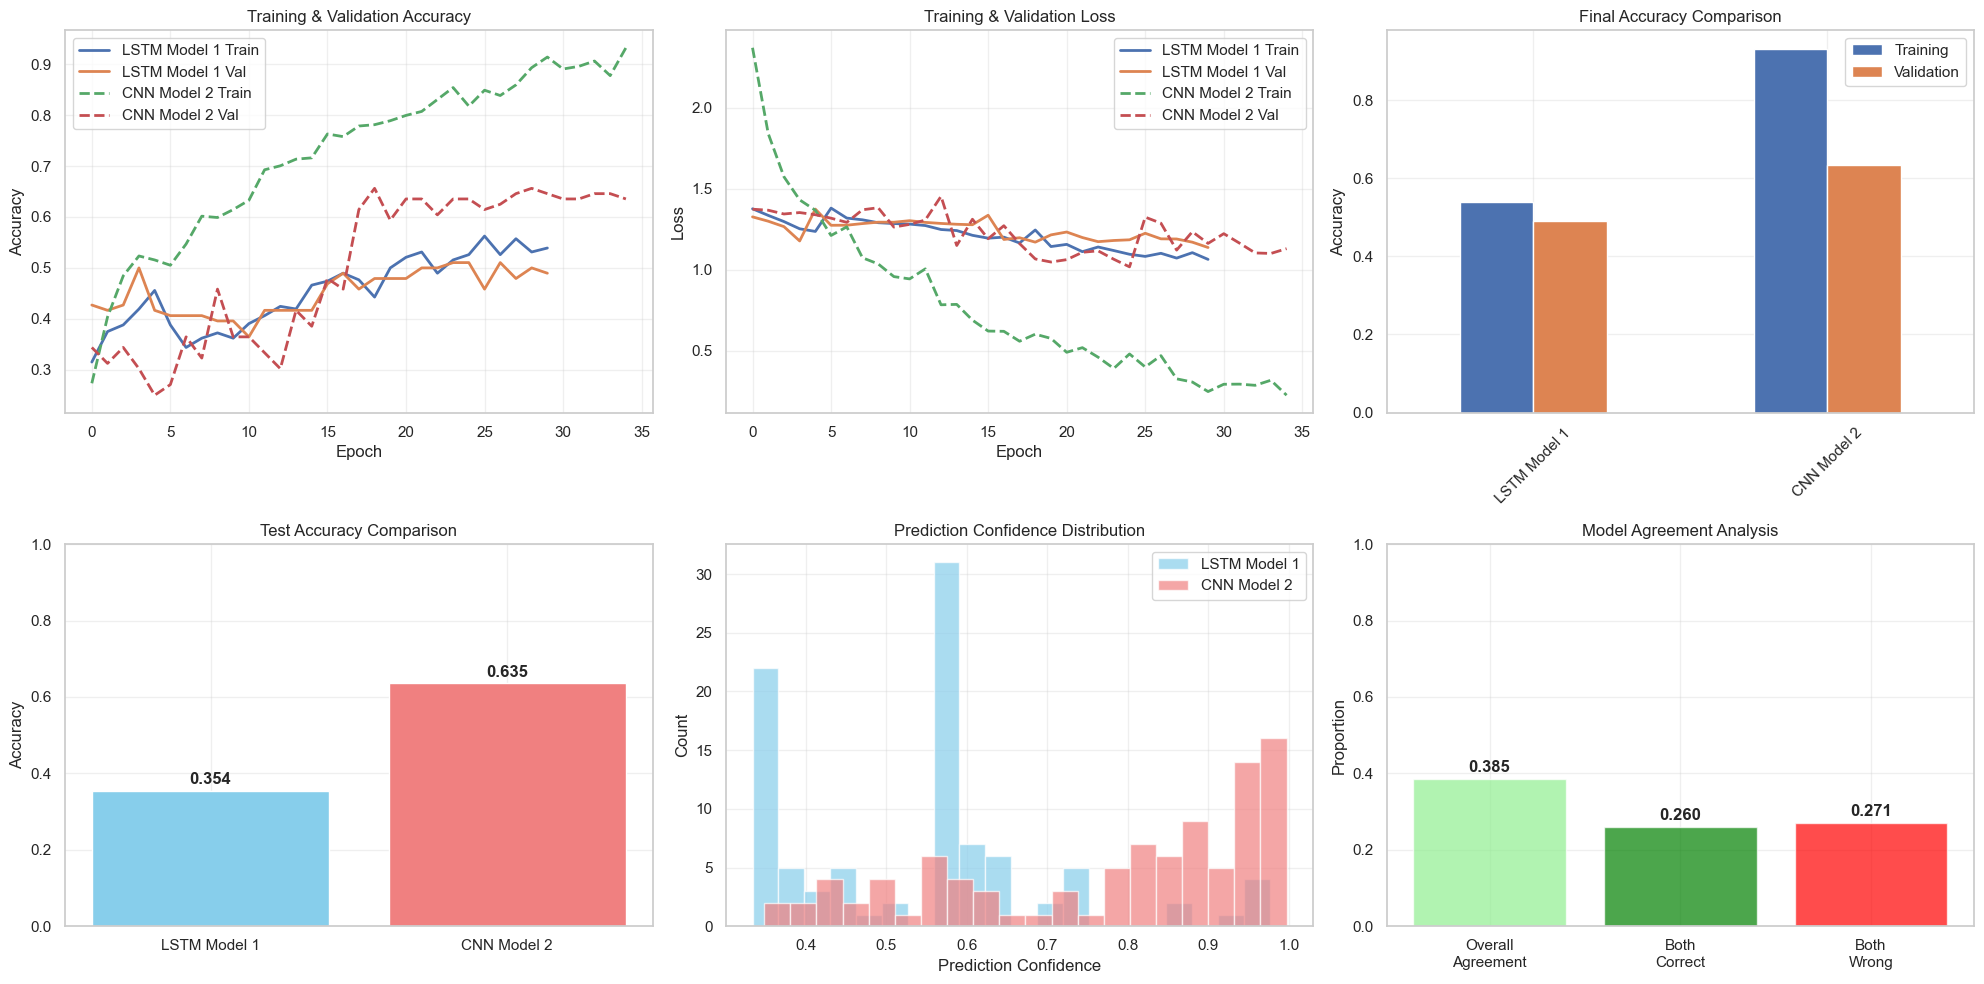


DETAILED PERFORMANCE COMPARISON
              Metric LSTM Model 1 CNN Model 2
Final Train Accuracy       0.5391      0.9323
  Final Val Accuracy       0.4896      0.6354
       Test Accuracy       0.3542      0.6354
    Final Train Loss       1.0639      0.2245
      Final Val Loss       1.1374      1.1302
     Training Epochs           30          35
     Mean Confidence       0.5406      0.7810
      Std Confidence       0.1622      0.1940

MODEL AGREEMENT ANALYSIS
Models agree on: 38.5% of predictions
Both models correct: 26.0%
Both models wrong: 27.1%

Disagreement cases: 59 out of 96
Sample disagreements:
   actual model1_pred model2_pred  model1_conf  model2_conf
   Chopin        Bach      Chopin     0.734360     0.997547
   Chopin   Beethoven      Chopin     0.358305     0.851230
   Chopin      Chopin      Mozart     0.615464     0.507507
     Bach      Chopin        Bach     0.623072     0.985492
   Chopin      Chopin   Beethoven     0.580278     0.915827
   Mozart      Mozart

In [32]:
# Model Comparison: LSTM Model 1 vs CNN Model 2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

def compare_models(model1, model2, history1, history2, X1_val, X2_val, y_val, model_names=["Model 1", "Model 2"]):
    """
    Comprehensive comparison between two trained models
    """
    print("="*60)
    print("ML MODEL COMPARISON")
    print("="*60)
    
    # 1. Training History Comparison
    plt.figure(figsize=(20, 10))
    
    # Accuracy comparison
    plt.subplot(2, 3, 1)
    plt.plot(history1.history['accuracy'], label=f'{model_names[0]} Train', linewidth=2)
    plt.plot(history1.history['val_accuracy'], label=f'{model_names[0]} Val', linewidth=2)
    plt.plot(history2.history['accuracy'], label=f'{model_names[1]} Train', linewidth=2, linestyle='--')
    plt.plot(history2.history['val_accuracy'], label=f'{model_names[1]} Val', linewidth=2, linestyle='--')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Loss comparison
    plt.subplot(2, 3, 2)
    plt.plot(history1.history['loss'], label=f'{model_names[0]} Train', linewidth=2)
    plt.plot(history1.history['val_loss'], label=f'{model_names[0]} Val', linewidth=2)
    plt.plot(history2.history['loss'], label=f'{model_names[1]} Train', linewidth=2, linestyle='--')
    plt.plot(history2.history['val_loss'], label=f'{model_names[1]} Val', linewidth=2, linestyle='--')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Final Performance Metrics
    plt.subplot(2, 3, 3)
    final_metrics = {
        model_names[0]: {
            'train_acc': history1.history['accuracy'][-1],
            'val_acc': history1.history['val_accuracy'][-1],
            'train_loss': history1.history['loss'][-1],
            'val_loss': history1.history['val_loss'][-1]
        },
        model_names[1]: {
            'train_acc': history2.history['accuracy'][-1],
            'val_acc': history2.history['val_accuracy'][-1],
            'train_loss': history2.history['loss'][-1],
            'val_loss': history2.history['val_loss'][-1]
        }
    }
    
    metrics_df = pd.DataFrame(final_metrics).T
    metrics_df[['train_acc', 'val_acc']].plot(kind='bar', ax=plt.gca())
    plt.title('Final Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.legend(['Training', 'Validation'])
    plt.grid(True, alpha=0.3)
    
    # 3. Predictions and Detailed Metrics
    y_pred1 = model1.predict(X1_val)
    y_pred1_classes = np.argmax(y_pred1, axis=1)
    y_pred2 = model2.predict(X2_val)
    y_pred2_classes = np.argmax(y_pred2, axis=1)
    
    # Accuracy comparison
    acc1 = accuracy_score(y_val, y_pred1_classes)
    acc2 = accuracy_score(y_val, y_pred2_classes)
    
    plt.subplot(2, 3, 4)
    plt.bar([model_names[0], model_names[1]], [acc1, acc2], color=['skyblue', 'lightcoral'])
    plt.title('Test Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    for i, v in enumerate([acc1, acc2]):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Confidence comparison
    conf1 = np.max(y_pred1, axis=1)
    conf2 = np.max(y_pred2, axis=1)
    
    plt.subplot(2, 3, 5)
    plt.hist(conf1, alpha=0.7, label=model_names[0], bins=20, color='skyblue')
    plt.hist(conf2, alpha=0.7, label=model_names[1], bins=20, color='lightcoral')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Count')
    plt.title('Prediction Confidence Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Agreement between models
    plt.subplot(2, 3, 6)
    agreement = (y_pred1_classes == y_pred2_classes).mean()
    both_correct = ((y_pred1_classes == y_val) & (y_pred2_classes == y_val)).mean()
    both_wrong = ((y_pred1_classes != y_val) & (y_pred2_classes != y_val)).mean()
    
    agreement_data = [agreement, both_correct, both_wrong]
    labels = ['Overall\nAgreement', 'Both\nCorrect', 'Both\nWrong']
    colors = ['lightgreen', 'green', 'red']
    
    plt.bar(labels, agreement_data, color=colors, alpha=0.7)
    plt.title('Model Agreement Analysis')
    plt.ylabel('Proportion')
    plt.ylim(0, 1)
    for i, v in enumerate(agreement_data):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 4. Detailed Performance Table
    print("\n" + "="*60)
    print("DETAILED PERFORMANCE COMPARISON")
    print("="*60)
    
    comparison_table = pd.DataFrame({
        'Metric': ['Final Train Accuracy', 'Final Val Accuracy', 'Test Accuracy', 
                   'Final Train Loss', 'Final Val Loss', 'Training Epochs',
                   'Mean Confidence', 'Std Confidence'],
        model_names[0]: [
            f"{final_metrics[model_names[0]]['train_acc']:.4f}",
            f"{final_metrics[model_names[0]]['val_acc']:.4f}",
            f"{acc1:.4f}",
            f"{final_metrics[model_names[0]]['train_loss']:.4f}",
            f"{final_metrics[model_names[0]]['val_loss']:.4f}",
            len(history1.history['accuracy']),
            f"{np.mean(conf1):.4f}",
            f"{np.std(conf1):.4f}"
        ],
        model_names[1]: [
            f"{final_metrics[model_names[1]]['train_acc']:.4f}",
            f"{final_metrics[model_names[1]]['val_acc']:.4f}",
            f"{acc2:.4f}",
            f"{final_metrics[model_names[1]]['train_loss']:.4f}",
            f"{final_metrics[model_names[1]]['val_loss']:.4f}",
            len(history2.history['accuracy']),
            f"{np.mean(conf2):.4f}",
            f"{np.std(conf2):.4f}"
        ]
    })
    
    print(comparison_table.to_string(index=False))
    
    # 5. Agreement Analysis
    print(f"\n{'='*60}")
    print("MODEL AGREEMENT ANALYSIS")
    print(f"{'='*60}")
    print(f"Models agree on: {agreement:.1%} of predictions")
    print(f"Both models correct: {both_correct:.1%}")
    print(f"Both models wrong: {both_wrong:.1%}")
    
    # Cases where models disagree
    disagreement_mask = y_pred1_classes != y_pred2_classes
    if disagreement_mask.sum() > 0:
        print(f"\nDisagreement cases: {disagreement_mask.sum()} out of {len(y_val)}")
        print("Sample disagreements:")
        
        le = LabelEncoder()
        le.fit(df_song_features['artist'])
        artist_names = le.classes_
        
        disagreement_df = pd.DataFrame({
            'actual': [artist_names[i] for i in y_val[disagreement_mask][:10]],
            'model1_pred': [artist_names[i] for i in y_pred1_classes[disagreement_mask][:10]],
            'model2_pred': [artist_names[i] for i in y_pred2_classes[disagreement_mask][:10]],
            'model1_conf': conf1[disagreement_mask][:10],
            'model2_conf': conf2[disagreement_mask][:10]
        })
        print(disagreement_df.to_string(index=False))
    
    return {
        'model1_accuracy': acc1,
        'model2_accuracy': acc2,
        'agreement': agreement,
        'both_correct': both_correct,
        'comparison_table': comparison_table
    }

# Run the comparison
comparison_results = compare_models(
    model_lstm, model_cnn, 
    history, history_cnn, 
    X_seq_val, X_cnn_val, y_val,
    model_names=["LSTM Model 1", "CNN Model 2"]
)

### Model Optimization: Optimize the deep learning model by fine-tuning hyperparameters.

Experimenting on hyperparameters for both LSTM and CNN, to understand how we could get better results. 

In [36]:

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# --- LSTM Hyperparameter Tuning ---

def build_lstm_model(units1=128, units2=64, dropout=0.3, lr=0.001):
    model = Sequential()
    model.add(Input(shape=(X_seq_train.shape[1], X_seq_train.shape[2])))
    model.add(LSTM(units1, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units2))
    model.add(Dropout(dropout))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(y_seq_train.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])
    return model

# Create KerasClassifier with explicit parameter mapping
lstm_model = KerasClassifier(
    model=build_lstm_model,
    epochs=10, 
    batch_size=64, 
    verbose=0,
    # Explicitly declare model parameters
    units1=128,
    units2=64,
    dropout=0.3,
    lr=0.001
)

# Define parameter grid
lstm_param_grid = {
    'model__units1': [64, 128, 256],        # Note the 'model__' prefix
    'model__units2': [32, 64, 128],
    'model__dropout': [0.2, 0.3, 0.5],
    'model__lr': [1e-2, 1e-3, 1e-4],
    'batch_size': [32, 64, 128],
    'epochs': [10, 20]
}

lstm_search = RandomizedSearchCV(lstm_model, lstm_param_grid, n_iter=10, cv=2, verbose=2)
lstm_search.fit(X_seq_train, y_seq_train)

print("Best LSTM params:", lstm_search.best_params_)

# --- CNN Hyperparameter Tuning ---

def build_cnn_model(filters1=64, filters2=128, dense_units=256, dropout=0.5, optimizer__learning_rate=0.001):
    model = Sequential([
        Input(shape=(X_cnn_train.shape[1], 1)),
        Conv1D(filters=filters1, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(dropout),
        Conv1D(filters=filters2, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(dropout),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout),
        Dense(len(np.unique(y_train)), activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=optimizer__learning_rate), 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

cnn_model = KerasClassifier(model=build_cnn_model, 
                            epochs=10, batch_size=32, verbose=0,
                            filters1=128,
                            filters2=64,
                            dense_units=256,
                            dropout=0.3,
                            optimizer__learning_rate=0.001
                            )

cnn_param_grid = {
    'filters1': [32, 64, 128],
    'filters2': [64, 128, 256],
    'dense_units': [128, 256, 512],
    'dropout': [0.3, 0.5],
    'optimizer__learning_rate': [1e-2, 1e-3, 1e-4],
    'batch_size': [16, 32, 64],
    'epochs': [10, 20]
}

print("Starting CNN hyperparameter tuning...")
cnn_search = RandomizedSearchCV(cnn_model, cnn_param_grid, n_iter=10, cv=2, verbose=2)
cnn_search.fit(X_cnn_train, y_train)    

print("Best CNN params:", cnn_search.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END batch_size=64, epochs=20, model__dropout=0.5, model__lr=0.001, model__units1=128, model__units2=128; total time=   5.5s
[CV] END batch_size=64, epochs=20, model__dropout=0.5, model__lr=0.001, model__units1=128, model__units2=128; total time=   5.3s
[CV] END batch_size=64, epochs=10, model__dropout=0.5, model__lr=0.001, model__units1=128, model__units2=32; total time=   2.1s
[CV] END batch_size=64, epochs=10, model__dropout=0.5, model__lr=0.001, model__units1=128, model__units2=32; total time=   2.2s
[CV] END batch_size=128, epochs=20, model__dropout=0.5, model__lr=0.01, model__units1=256, model__units2=128; total time=   8.0s
[CV] END batch_size=128, epochs=20, model__dropout=0.5, model__lr=0.01, model__units1=256, model__units2=128; total time=   7.9s
[CV] END batch_size=128, epochs=10, model__dropout=0.2, model__lr=0.0001, model__units1=64, model__units2=64; total time=   1.9s
[CV] END batch_size=128, epochs=10, mo